#LSR - Paikallinen lepostandardi

Tutki lähimpien tähtien ($U,V,W$)-nopeuksia efektiivisen lämpötilan $T_{\rm eff}$ funktiona 

Lataa tarvittavat python-paketit.

In [4]:
import numpy as np
from numpy import array,append,arange,zeros,exp,sin,random,std
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors

import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.coordinates import Angle

Lataa Gaia-arkiston taulukot.

In [5]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3

tables = Gaia.load_tables(only_names=True)
#for table in (tables):
#    print (table.get_qualified_name())


INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


Etsi tähtiä 200 pc säteellä Auringosta. 

Valitse vain ne, joilla parallaksin ja säteisnopeuden virheet ovat pieniä, ja joille on määrätty efektiivinen lämpötila Gaia-väreistä. 

(Haku voi kestää tovin.)

In [7]:
job0 = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source \
WHERE visibility_periods_used >=5 \
AND (parallax) >5.0 \
AND parallax_over_error > 10.0 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND ABS(pmra/pmra_error)>10.0 \
AND ABS(pmdec/pmdec_error)>10.0 \
AND RUWE < 1.5 \
AND teff_gspphot IS NOT NULL \
AND radial_velocity_error < 5.0 \
AND radial_velocity IS NOT NULL;",dump_to_file=False)

INFO: Query finished. [astroquery.utils.tap.core]


Anna otokselle nimi "r". Tutki sen kokoa.

In [8]:
r = job0.get_results()
print (r['parallax', 'pmra','radial_velocity', 'teff_gspphot'])

     parallax              pmra        radial_velocity teff_gspphot
       mas               mas / yr           km / s          K      
------------------ ------------------- --------------- ------------
13.398257319108815  -49.35844067323052       12.315269     3730.103
 6.106723881526058   5.650983532208639      -11.030197    4747.2764
 5.948736623759927 -16.618858274260234       3.3522851    10316.087
19.588654431566606  11.454067954459212         45.4255     7051.192
 5.581347934370235 -4.5530993398870985       -7.671485    4975.5107
10.326265936660176   6.066630513795433       7.0510607     3796.808
               ...                 ...             ...          ...
 5.522229715353551    6.81632347775003      -1.7443135    4232.8203
 5.859204138747633  -28.03009148415873       41.802498    4631.3296
 6.723701787034956  -23.64662630433201       1.1864713    6627.0254
5.3450782735827795  2.7356503991548884       27.328995     6511.662
10.811695331683428 -49.400006214547616        -6

Määrittele paikka- ja nopeuskoordinaatit ekvatoriaalisessa koordinaatistossa.

In [9]:
distance=1.0/(r['parallax'].data)
ra=(r['ra'].data)*degr
print(type(ra))
dec=(r['dec'].data)*degr
print(type(dec))
vrad=r['radial_velocity'].data
talpha=4.74*r['pmra'].data*distance
tdelta=4.74*r['pmdec'].data*distance
teff=r['teff_gspphot']

vequatorial=array([[vrad],[talpha],[tdelta]]).reshape(3,len(distance))

#print(vequatorial)
print(type(vequatorial))

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ndarray'>


Määrittele muunnosmatriisi heliosentristen ($\dot{x},\dot{y},\dot{z}$)-koordinaattien laskemiseksi.

In [10]:
Rydelta=zeros((3,3,len(distance)))

for i in range(len(distance)):
         Rydelta[:,:,i]=[[np.cos(dec[i]),0.0,-np.sin(dec[i])],
                         [0.0,1.0,0.0],
                        [np.sin(dec[i]),0.0,np.cos(dec[i])]]
  

Rzalpha=zeros((3,3,len(distance)))

for i in range(len(distance)):
         Rzalpha[:,:,i]=[[np.cos(ra[i]),-np.sin(ra[i]),0.0],
                        [np.sin(ra[i]),np.cos(ra[i]),0.0],
                        [0.0,0.0,1.0]]


Rottoxyz=zeros((3,3,len(distance)))

for i in range(len(distance)):
         Rottoxyz[:,:,i]=np.matmul(Rzalpha[:,:,i],Rydelta[:,:,i])
        
print(type(Rottoxyz))

<class 'numpy.ndarray'>


Muunna ($v_r,t_\alpha,t_\delta$)-vektorit ($\dot{x},\dot{y},\dot{z}$)-nopeuksiksi.

In [11]:
xyzdots=zeros((3,len(distance)))
for i in range(len(distance)):
         xyzdots[:,i]=np.matmul(Rottoxyz[:,:,i],vequatorial[:,i])
        
print(type(xyzdots))
print(xyzdots.shape)

<class 'numpy.ndarray'>
(3, 414490)


Laske heliosentriset ($x,y,z$)-koordinaatit etäisyyden, rektaskension ja deklinaation ($d,\alpha,\delta$) avulla,

In [12]:
#print(dec)
d=zeros((len(distance)))
for i in range(len(distance)):
    d[i]=distance[i]
    
xyzs=d*array([[np.cos(ra)*np.cos(dec)],
                    [np.sin(ra)*np.cos(dec)],
                    [np.sin(dec)]]).reshape(3,len(distance))


#requatorial=array(distance)
print(type(xyzs))
print(xyzs.shape)
print(xyzs)


<class 'numpy.ndarray'>
(3, 414490)
[[-0.01494917 -0.03338747 -0.03531792 ... -0.00690509 -0.00737069
  -0.00904649]
 [-0.04491263 -0.09747872 -0.09875706 ... -0.07180151 -0.07884785
  -0.11369282]
 [-0.05770612 -0.12727342 -0.13137077 ... -0.05789399 -0.06315852
  -0.08947733]]


Laske heliosentriset ($X,Y,Z$)-koordinatit sekä ($U,V,W$)-nopeudet.

Määrittele muunnosmatriisi ekvatoriaalisen ja galaktisen koordinaatiston välillä.

In [13]:
#T=Rz(90-theta)Rx(90-deltaP)Rz(90+alphaP)
#with angles from Liu et al. A&A 536, A102 (2011)
raGP=Angle('12:51:26.2755 hours')  # R.A. of the North Galactic Pole
decGP=Angle('27:07:41.704 degrees') # Dec. of the NGP 
clonGC=Angle('122.93191857 degrees')          # complement of galactic longitude of the G.Centre
phi=np.pi/2.0-clonGC.radian
psi=np.pi/2.0+raGP.radian
theta=np.pi/2.0-decGP.radian
degr=np.pi/180.0
print('Psi =', psi/degr)
print('theta = ',theta/degr)
print('phi = ',phi/degr)


Rzpsi=[[np.cos(psi),np.sin(psi),0.0],[-np.sin(psi),np.cos(psi),0.0],[0.0,0.0,1.0]]
Rxtheta=[[1.0,0.0,0.0],[0.0,np.cos(theta),np.sin(theta)],[0.0,-np.sin(theta),np.cos(theta)]]
Rzphi=[[np.cos(phi),np.sin(phi),0.0],[-np.sin(phi),np.cos(phi),0.0],[0.0,0.0,1.0]]
TR=np.matmul(Rzphi,np.matmul(Rxtheta,Rzpsi))    
       
print('T=')    
print(TR)   

Psi = 282.85948125
theta =  62.87174888888889
phi =  -32.93191856999999
T=
[[-0.05487554 -0.8734371  -0.48383499]
 [ 0.49410945 -0.44482959  0.74698225]
 [-0.86766614 -0.19807639  0.45598379]]


In [14]:
print(type(TR))
print(TR.shape)
print(type(xyzs))
print(xyzs.shape)

BigXYZ=np.matmul(TR,xyzs)
print(type(BigXYZ))
print(BigXYZ.shape)

BigUVW=np.matmul(TR,xyzdots)
print(type(BigUVW))
print(BigUVW.shape)

<class 'numpy.ndarray'>
(3, 3)
<class 'numpy.ndarray'>
(3, 414490)
<class 'numpy.ndarray'>
(3, 414490)
<class 'numpy.ndarray'>
(3, 414490)


Nopeuksilla on suuri hajonta. Määrittele $T_{\rm eff}$-välit (bins) keskiarvojen laskemista varten.

In [15]:
bins = 4.0e3+5.0e2*arange(15)

U=BigUVW[0,:]
V=BigUVW[1,:]
W=BigUVW[2,:]

midbins = 4.5e3+5.0e2*arange(len(bins))

ubinaves=zeros((len(bins)))
vbinaves=zeros((len(bins)))
wbinaves=zeros((len(bins)))

for i in range(len(bins)-1):
     lo=bins[i]
     hi=bins[i+1]   
     index1=np.where(teff > lo)
     index2=np.where(teff[index1] <=hi)   
     ubinaves[i]=np.mean(U[index1][index2])
     vbinaves[i]=np.mean(V[index1][index2])
     wbinaves[i]=np.mean(W[index1][index2])
    
    
    

Plottaa $U$-nopeudet ja niiden keskiarvot efektiivisen lämpötilan $T_{\rm eff}$ funktiona.

(-50.0, 25.0)

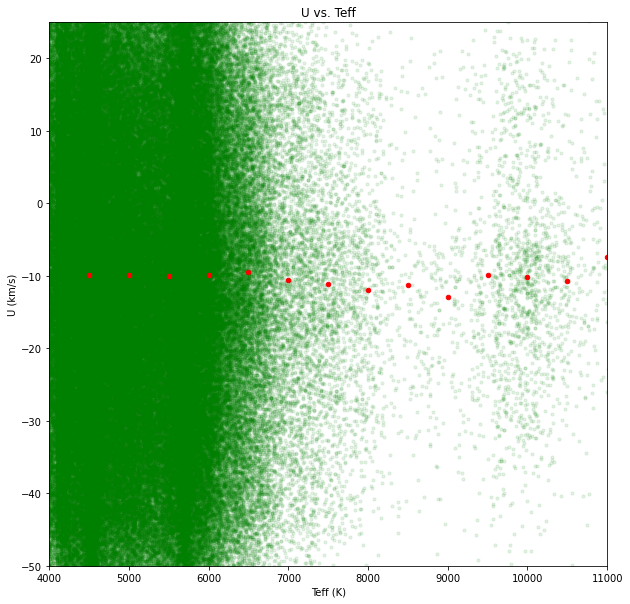

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(teff, U, alpha=0.1, s=10, color='g', zorder=0)
ax.scatter(midbins, ubinaves, alpha=1, s=20, color='r', zorder=0)

#plt.plot(dvector,vrvector,color='r')
plt.xlim(4000,11000)
plt.title('U vs. Teff')
plt.ylabel('U (km/s)')
plt.xlabel('Teff (K)')
plt.ylim(-50,25)

Plottaa $V$-nopeudet ja niiden keskiarvot efektiivisen lämpötilan $𝑇_{\rm eff}$ funktiona.

(-50.0, 25.0)

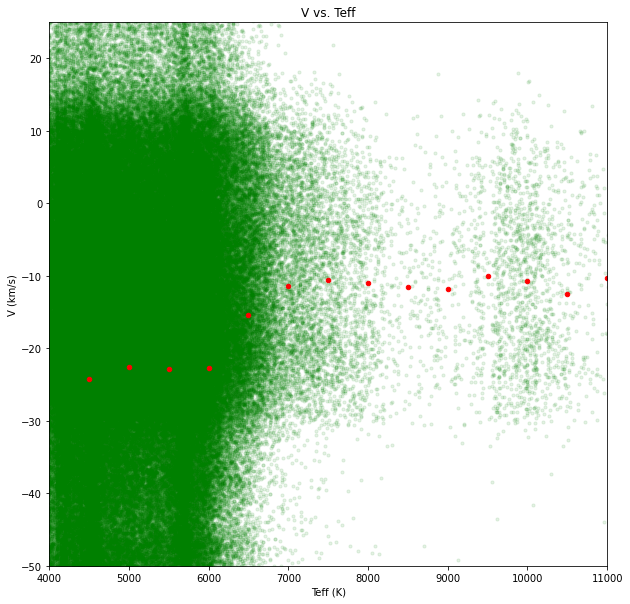

In [17]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(teff, V, alpha=0.1, s=10, color='g', zorder=0)
ax.scatter(midbins, vbinaves, alpha=1, s=20, color='r', zorder=1)

#plt.plot(dvector,vrvector,color='r')
plt.xlim(4000,11000)
plt.title('V vs. Teff')
plt.ylabel('V (km/s)')
plt.xlabel('Teff (K)')
plt.ylim(-50,25)

Plottaa $W$-nopeudet ja niiden keskiarvot efektiivisen lämpötilan $𝑇_{\rm eff}$ funktiona.

(-50.0, 25.0)

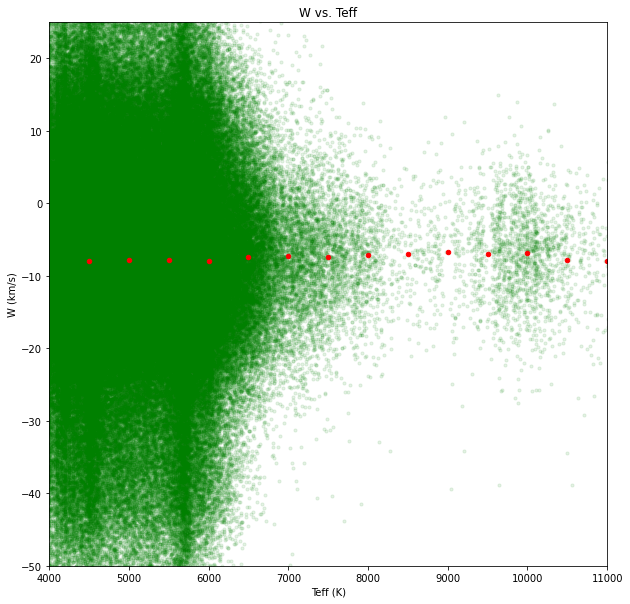

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(teff, W, alpha=0.1, s=10, color='g', zorder=0)
ax.scatter(midbins, wbinaves, alpha=1, s=20, color='r', zorder=0)

#plt.plot(dvector,vrvector,color='r')
plt.xlim(4000,11000)
plt.title('W vs. Teff')
plt.ylabel('W (km/s)')
plt.xlabel('Teff (K)')
plt.ylim(-50,25)

Tulosta keskimääräiset $(U,V,W)$-nopeudet eri $T_{\rm eff}$-arvoille  

In [112]:
print('Teff','<U>','<V>','<W>')
for i in range(len(midbins)-1):
      print("%5d" % midbins[i],"%.1f" % ubinaves[i],"%.1f" % vbinaves[i],"%.1f" %wbinaves[i])

Teff <U> <V> <W>
 4500 -9.8 -24.2 -7.9
 5000 -9.9 -22.6 -7.7
 5500 -10.1 -22.8 -7.8
 6000 -9.8 -22.7 -7.9
 6500 -9.5 -15.4 -7.4
 7000 -10.5 -11.4 -7.2
 7500 -11.2 -10.5 -7.4
 8000 -12.0 -10.9 -7.1
 8500 -11.3 -11.5 -7.0
 9000 -13.0 -11.8 -6.6
 9500 -9.9 -10.1 -7.0
10000 -10.2 -10.7 -6.8
10500 -10.8 -12.5 -7.8
11000 -7.3 -10.3 -8.0


$U$- ja $W$-nopeuksien keskiarvot ovat suurinpiirtein vakioita, kun taas $V$-nopeuksissa tapahtuu selvä hyppäys noin $T_{\rm eff}\sim7000$ K kohdalla. Tämä on osoitus siitä, että vanhat tähdet jäävät keskimäärin jälkeen Linnunradan kiertoliikkeestä. Syynä on tähtien nopeushajonnan kasvu iän myötä sironnan seurauksena. Tätä kutsutaan epäsymmetriseksi ajautumiseksi (asymmetric drift). Koska kuumat tähdet ovat lyhytikäisiä, ne ovat keskimäärin nuorempia kuin viileät tähdet.   

Oletetaan, että kuumille tähdille mitatut nopeudet kuvastavat auringon liikettä LSR:n suhteen.

Lasketaan auringon LSR-nopeus ($U_\odot,V_\odot,W_\odot$)  näiden keskiarvojen $<U>$, $<V>$ ja $<W>$ vastalukuna.

In [30]:
warm=np.where(midbins >=7000)
print('Auringon nopeuskomponentit LSR:n suhteen:')
print('U = ',"%.1f" % -np.mean(ubinaves[warm]),'km/s ', 
      'V = ',"%.1f" % -np.mean(vbinaves[warm]),'km/s ',
      'W = ',"%.1f" % -np.mean(wbinaves[warm]),'km/s ')

Auringon nopeuskomponentit LSR:n suhteen:
U =  9.6 km/s  V =  10.0 km/s  W =  6.5 km/s 
